<a href="https://colab.research.google.com/github/zahra-sharifzadeh/pytorch/blob/main/01_pytorch_workflow_Putting_Together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# importing module that you need

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

torch.__version__

'1.13.1+cu116'

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}") 

Using device: cuda


In [4]:
!nvidia-smi

Mon Mar 27 22:13:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

###1.DATA

In [5]:
# Creat data for regression y = weight * X + bias

weight = 0.7
bias = 0.3

# Creat range values

start = 0
step = 0.02
end = 1

# Creat X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [6]:
print("some of X =", X[:5])
print("some of y=", y[:5])
print("length of X:",len(X), "and length of y:", len(y))

some of X = tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800]])
some of y= tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560]])
length of X: 50 and length of y: 50


In [7]:
# Train and Test split
Train_split = int(0.8 * len(X))

# Train Data
X_train, y_train = X[:Train_split], y[:Train_split]

# Test Data
X_test, y_test = X[Train_split:], y[Train_split:] 

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [13]:
def plot_prediction(
    train_data=X_train,
    train_labels=y_train,
    test_data=X_test,
    test_labels=y_test,
    predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10,7))

  #plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  #plot testing data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  #plot the predictions is available in red

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Prediction")

  # show the legend
  plt.legend(prop={"size": 14})
  plt.show()


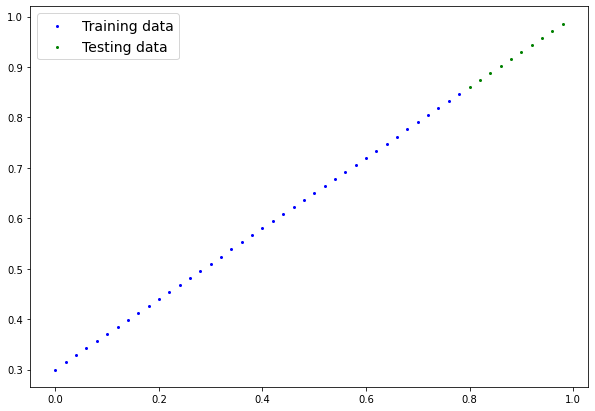

In [14]:
# plot the data 
plot_prediction()

In [15]:
X_train.dtype

torch.float32

### Building Linear Model

In [22]:
# Creat A linear model by subclassing nn.module Version 1
class LinearRegressionModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.weghits = nn.Parameter(torch.randn(1,
                                             dtype =torch.float),
                                            requires_grad=True)
                                           
    self.bias = nn.Parameter(torch.randn(1,
                                        dtype=torch.float),
                                         requires_grad=True)
                            
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

In [28]:
model_0 = LinearRegressionModelV1()
model_0, model_0.state_dict()

(LinearRegressionModelV1(),
 OrderedDict([('weghits', tensor([0.3367])), ('bias', tensor([0.1288]))]))

In [31]:
# Creat A linear model by subclassing nn.module Version 2
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear for creating model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
                                  
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:

      return self.linear_layer(x)

    

In [32]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [41]:
print(next(model_1.parameters()).device)

model_1.to(device)

print(next(model_1.parameters()).device)

cpu
cuda:0


### 3.Training